In [53]:
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from IPython.display import display
from sklearn.neural_network import MLPClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, precision_recall_fscore_support

In [2]:
# Data manipulation
import pandas as pd
import numpy as np


# Splitting data
from sklearn.model_selection import train_test_split

In [3]:
from scipy import stats
from scipy import spatial
from gensim.models import KeyedVectors

In [4]:
word2vec = KeyedVectors.load_word2vec_format('../word2vec/W2V_150.txt', binary=False)      
#test embedding
print(word2vec['a_dua'])
import random
print(np.random.randn(150))

[-1.096853    0.1238883   1.713642    2.17519    -0.5785002  -2.027245
  0.4998034  -0.7409065  -1.753515   -1.095152    0.7456962   1.484329
  1.235524    1.025137   -0.4033328  -0.9089296  -0.2022127   0.9581299
  0.6957457   1.385916    0.4481485   1.238998    0.1075599   3.29651
  1.315556    0.4587597   2.277924   -1.313732    0.9624746  -0.2428055
 -0.9468833   0.8783497   0.3211554  -0.5890836   0.9027938  -1.178614
 -0.7399899  -1.011717    1.766519   -2.162154    0.9139196  -2.295288
 -1.206698   -2.222441   -1.830276   -0.4457759   1.122905    0.3227312
 -0.03411892 -0.7967375   0.1875879   0.3892174  -0.7192345  -0.5432259
 -0.6546717  -0.7268866   0.5100322   0.9201084   0.2751797   1.194452
  0.5092697  -0.3654743  -1.434594   -1.484043    1.105507    0.02227577
 -1.812047   -1.204937   -3.369251    0.6383803   0.1732161  -0.478294
 -0.5762202   0.1084443  -0.1128882   0.647718   -0.3459211   0.5320156
  0.239954   -2.538636   -0.7471865   1.441165    0.02344817 -0.9431902

In [17]:
class EmbGetter:
    def __init__(self, model):
        self.model = model
        self.emb_dim = model["a_dua"].shape[0]
    def get(self, s):
        if s in self.model:
            return self.model[s]
        else:
            return np.random.randn(self.emb_dim)
    def contains(self, s):
        return s in self.model
    
emb_getter = EmbGetter(word2vec)

In [33]:
def pearson(e1, e2):
    return stats.pearsonr(e1, e2)[0]

def spearman_rank(e1, e2):
    return stats.spearmanr(e1, e2)[0]

def dot_product(e1, e2):
    return np.dot(e1, e2)

def euclidean(e1, e2):
    return 1 - spatial.distance.euclidean(e1, e2)

def make_feature(input_table):
    features = input_table.copy()
    features['first_emb'] = features.apply(lambda row: emb_getter.get(row['Word1']), axis=1)
    features['second_emb'] = features.apply(lambda row: emb_getter.get(row['Word2']), axis=1)
    display(features)
    features['cos'] = features.apply(lambda row: 1 - spatial.distance.cosine(row['first_emb'], row['second_emb']), axis=1)
    features['norm_of_diff'] = features.apply(lambda row: np.linalg.norm(row['first_emb'] - row['second_emb']), axis=1)
    features['pearson'] = features.apply(lambda row: pearson(row['first_emb'], row['second_emb']), axis=1)
    features['spearman_rank'] = features.apply(lambda row: spearman_rank(row['first_emb'], row['second_emb']), axis=1)
    features['dot_product'] = features.apply(lambda row: dot_product(row['first_emb'], row['second_emb']), axis=1)
    features['euclidean'] = features.apply(lambda row: euclidean(row['first_emb'], row['second_emb']), axis=1)
    features['emb_miss'] = features.apply(lambda row: 0 if (emb_getter.contains(row['Word1']) and emb_getter.contains(row['Word2'])) else 1, axis=1)
    features = features.loc[features['emb_miss'] == 0]
#     features = features.drop(columns = ["emb_miss"])
    return features


In [96]:
# load test data
p1 = pd.read_table("../datasets/ViCon-400/400_noun_pairs.txt", sep="\t")
p2 = pd.read_table("../datasets/ViCon-400/400_verb_pairs.txt", sep="\t")
p3 = pd.read_table("../datasets/ViCon-400/600_adj_pairs.txt", sep="\t")

test_data = pd.concat([p1, p2, p3])

test_data['label'] = test_data.apply(lambda row: 1 if row['Relation'] == 'ANT' else 0, axis=1)
test_data = test_data.reset_index().drop(columns = ['Relation', 'index'])
display(test_data)
test_features = make_feature(test_data)
display(test_features)
X_test = test_features.drop(columns=["Word1", "Word2", "first_emb", "second_emb", "label"])
y_test = np.array(test_features['label'].astype(np.int32)).reshape((-1, ))
display(X_test)

,Word1,Word2,label
0,khoái_lạc,nỗi_đau,1
1,yếu_kém,sức_mạnh,1
2,thanh_danh,ô_nhục,1
3,dây,dọc,0
4,bằng_cớ,chứng_cớ,0
...,...,...,...
1395,ấm_áp,lạnh_lẽo,1
1396,mập,ngẳng,1
1397,chóng,lâu,1
1398,chậm,sớm,1


,Word1,Word2,label,first_emb,second_emb
0,khoái_lạc,nỗi_đau,1,"[0.4649678, -0.5800779, -1.960368, -0.103116, ...","[1.001201, 0.872957, -0.5544619, 0.4246479, 2...."
1,yếu_kém,sức_mạnh,1,"[1.113018, 1.765621, 0.1503256, -0.8590851, -1...","[2.196333, 0.02373108, 0.8439404, 0.7745142, 1..."
2,thanh_danh,ô_nhục,1,"[0.03739062, 0.722598, 0.4939006, 1.180972, -0...","[-0.8631409, 0.5506324, 0.3692417, -0.00953786..."
3,dây,dọc,0,"[-0.8103815, -0.3776387, 1.287937, 1.714588, 0...","[1.430362, 0.1082051, -0.4619713, -0.4967797, ..."
4,bằng_cớ,chứng_cớ,0,"[-0.9261717824466239, -0.20208480731146752, -1...","[0.4331858, -0.3962619, -0.04544367, -0.427365..."
...,...,...,...,...,...
1395,ấm_áp,lạnh_lẽo,1,"[1.809414, -1.692015, -0.1252984, 1.332432, 1....","[0.952939, -0.2322295, -0.920751, 0.0289777, 2..."
1396,mập,ngẳng,1,"[1.486078, 1.108144, 1.496801, 1.327039, 0.951...","[0.8676309627735559, -1.6736589325193558, -0.5..."
1397,chóng,lâu,1,"[0.999721, -1.571221, 0.7342855, -0.8737525, -...","[-0.2226935, 0.6123096, 1.956545, 0.944621, -0..."
1398,chậm,sớm,1,"[1.008996, 0.9679081, -1.912266, 1.533196, -0....","[0.7396746, -0.6514262, -0.6998218, -0.4177481..."


,Word1,Word2,label,first_emb,second_emb,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,emb_miss
0,khoái_lạc,nỗi_đau,1,"[0.4649678, -0.5800779, -1.960368, -0.103116, ...","[1.001201, 0.872957, -0.5544619, 0.4246479, 2....",0.245766,16.834578,0.249734,0.271264,40.296856,-15.834578,0
1,yếu_kém,sức_mạnh,1,"[1.113018, 1.765621, 0.1503256, -0.8590851, -1...","[2.196333, 0.02373108, 0.8439404, 0.7745142, 1...",0.171372,18.374029,0.171366,0.166683,34.760422,-17.374029,0
2,thanh_danh,ô_nhục,1,"[0.03739062, 0.722598, 0.4939006, 1.180972, -0...","[-0.8631409, 0.5506324, 0.3692417, -0.00953786...",0.088986,16.266695,0.088963,0.034229,12.025043,-15.266695,0
3,dây,dọc,0,"[-0.8103815, -0.3776387, 1.287937, 1.714588, 0...","[1.430362, 0.1082051, -0.4619713, -0.4967797, ...",0.141662,16.180637,0.150397,0.135496,21.552877,-15.180637,0
5,ba,me,1,"[0.7750891, 0.034119, -0.5827036, -0.962679, 0...","[-0.1995596, -1.209143, -1.610082, 0.1992921, ...",-0.048281,15.954571,-0.048827,-0.042087,-5.739005,-14.954571,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1394,đê_hèn,cao_thượng,1,"[-0.3386852, 1.590143, 0.460648, 1.223749, 1.9...","[0.009528463, 0.6997741, -2.060155, 1.249025, ...",0.475772,13.905120,0.472447,0.473182,87.042557,-12.905121,0
1395,ấm_áp,lạnh_lẽo,1,"[1.809414, -1.692015, -0.1252984, 1.332432, 1....","[0.952939, -0.2322295, -0.920751, 0.0289777, 2...",0.629572,12.678332,0.628367,0.613533,136.498199,-11.678332,0
1397,chóng,lâu,1,"[0.999721, -1.571221, 0.7342855, -0.8737525, -...","[-0.2226935, 0.6123096, 1.956545, 0.944621, -0...",0.075829,21.526340,0.086772,0.106567,19.005964,-20.526340,0
1398,chậm,sớm,1,"[1.008996, 0.9679081, -1.912266, 1.533196, -0....","[0.7396746, -0.6514262, -0.6998218, -0.4177481...",0.415295,14.935099,0.414778,0.404510,75.847366,-13.935099,0


,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,emb_miss
0,0.245766,16.834578,0.249734,0.271264,40.296856,-15.834578,0
1,0.171372,18.374029,0.171366,0.166683,34.760422,-17.374029,0
2,0.088986,16.266695,0.088963,0.034229,12.025043,-15.266695,0
3,0.141662,16.180637,0.150397,0.135496,21.552877,-15.180637,0
5,-0.048281,15.954571,-0.048827,-0.042087,-5.739005,-14.954571,0
...,...,...,...,...,...,...,...
1394,0.475772,13.905120,0.472447,0.473182,87.042557,-12.905121,0
1395,0.629572,12.678332,0.628367,0.613533,136.498199,-11.678332,0
1397,0.075829,21.526340,0.086772,0.106567,19.005964,-20.526340,0
1398,0.415295,14.935099,0.414778,0.404510,75.847366,-13.935099,0


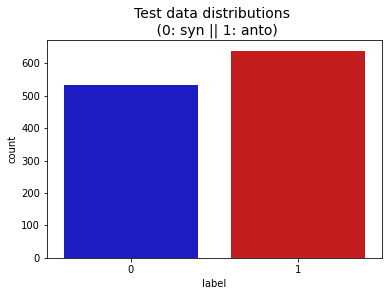

In [97]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x="label", data=test_features, palette=colors)
plt.title('Test data distributions \n (0: syn || 1: anto)', fontsize=14)
plt.show()

# sns.countplot(x="emb_miss", data=test_features, palette=colors)
# plt.title('Number of missing embedding for test data \n (0: not miss || 1: miss)', fontsize=14)
# plt.show()

In [101]:
#load train data
anto = pd.read_table("../antonym-synonym set/Antonym_vietnamese.txt", sep=" ", header=None)
syn = pd.read_table("../antonym-synonym set/Synonym_vietnamese.txt", sep=" ", header=None)
anto = pd.concat([anto] * 12)
# display(anto.tail())
# display(syn.tail())
anto["label"] = 1
syn["label"] = 0
data = pd.concat([syn, anto])
display(data)
data.columns = ["Word1", "Word2", "label"]

# REMOVE LEAKAGE DATA
data = data[~data.set_index(['Word1','Word2']).index.isin(test_features.set_index(['Word1','Word2']).index)].reset_index().drop(columns="index")
features = make_feature(data)
X = features.drop(columns=["Word1", "Word2", "first_emb", "second_emb", "label"])
y = np.array(features['label'].astype(np.int32)).reshape((-1, ))

display(X)

,0,1,label
0,a_dua,a_tòng,0
1,a_dua,vào_hùa,0
2,a_ma_tơ,tài_tử,0
3,a_tòng,vào_hùa,0
4,à_ơi,ạ_ơi,0
...,...,...,...
1995,bẩn_thỉu,sạch_sẽ,1
1996,bận,rảnh,1
1997,bận,rảnh_rang,1
1998,bận,rảnh_rỗi,1


,Word1,Word2,label,first_emb,second_emb
0,a_dua,a_tòng,0,"[-1.096853, 0.1238883, 1.713642, 2.17519, -0.5...","[-1.1202637360108096, 0.014703249937172501, -1..."
1,a_dua,vào_hùa,0,"[-1.096853, 0.1238883, 1.713642, 2.17519, -0.5...","[-0.1686348, 0.5090736, -0.06419589, 0.2851182..."
2,a_ma_tơ,tài_tử,0,"[-1.5295493592729057, -1.231183774202521, -0.7...","[-0.8984336, 0.04499664, -1.577926, -1.10538, ..."
3,a_tòng,vào_hùa,0,"[-0.5646141869407783, 2.380398311616743, 2.091...","[-0.1686348, 0.5090736, -0.06419589, 0.2851182..."
4,à_ơi,ạ_ơi,0,"[1.133512, 0.4620706, -0.5596249, 1.021484, 0....","[-0.8358990876402762, 1.102593066128674, 0.448..."
...,...,...,...,...,...
21053,báo_ân,báo_thù,1,"[0.4099637, 0.02193844, -0.5297902, 0.2062404,...","[-0.8177037, 0.4749404, -1.174358, -0.679406, ..."
21054,bần_tiện,hào_phóng,1,"[-1.2324221298287046, 2.2528961747015837, -0.6...","[1.40416, 2.75442, 0.2111574, 0.9635316, 1.135..."
21055,bận,rảnh,1,"[0.3057049, 3.127424, -1.285929, 0.6471007, -0...","[0.0487476, 1.200912, 0.1983149, -1.580838, 0...."
21056,bận,rảnh_rỗi,1,"[0.3057049, 3.127424, -1.285929, 0.6471007, -0...","[0.2521331, 0.4609424, -1.257721, -0.9162588, ..."


,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,emb_miss
1,0.288864,14.071492,0.287837,0.272092,34.252293,-13.071491,0
8,0.274868,17.656250,0.266121,0.315838,58.099056,-16.656250,0
15,0.442920,14.492322,0.465098,0.457405,79.485374,-13.492322,0
16,0.591152,14.334578,0.587056,0.566871,147.084900,-13.334577,0
18,0.446381,13.846804,0.446205,0.423658,56.181927,-12.846804,0
...,...,...,...,...,...,...,...
21051,-0.057208,22.310276,-0.041511,-0.013229,-12.072285,-21.310278,0
21053,0.044962,17.528137,0.053884,0.080386,5.950936,-16.528139,0
21055,0.471292,18.200443,0.471963,0.438350,146.509811,-17.200443,0
21056,0.479427,18.138960,0.479693,0.475966,150.581177,-17.138960,0


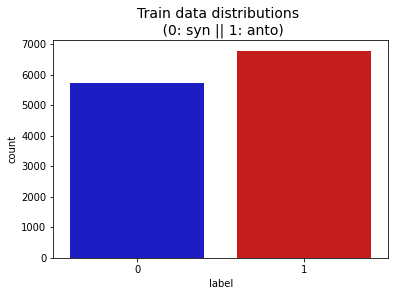

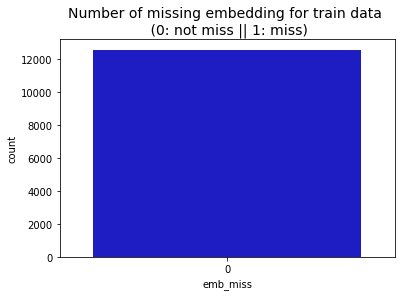

In [102]:
colors = ["#0101DF", "#DF0101"]

sns.countplot(x="label", data=features, palette=colors)
plt.title('Train data distributions \n (0: syn || 1: anto)', fontsize=14)
plt.show()

sns.countplot(x="emb_miss", data=X, palette=colors)
plt.title('Number of missing embedding for train data \n (0: not miss || 1: miss)', fontsize=14)
plt.show()

In [106]:
from sklearn.linear_model import *
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import random 

kf = KFold(n_splits=5, shuffle=True)

cnt = 1
'''
clf = MLPClassifier(hidden_layer_sizes=(2, 1), 
                                       solver='adam', 
                                       learning_rate='invscaling', 
                                       learning_rate_init=0.2,
                                      max_iter=1000)
RandomForestClassifier(n_estimators=10)
'''
# clfs = [make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear", max_iter=10000, class_weight="balanced",random_state=random.randint(0, 10000)))] * kf.n_splits               
clfs = [make_pipeline(StandardScaler(), RandomForestClassifier(n_estimators=1000))] * kf.n_splits               

f1 = list()
precision = list()
recall = list()

for train_index, test_index in kf.split(X, y):
    print(f'Fold:{cnt}, Train set: {len(train_index)}, Test set:{len(test_index)}')
    
    clfs[cnt - 1].fit(X.iloc[train_index], y[train_index])
    p, r, f, _ = precision_recall_fscore_support(y[test_index], clfs[cnt - 1].predict(X.iloc[test_index]), average="binary")
    print("Precision: ", p, "Recall: ", r, "F1: ", f)
    f1.append(f)
    precision.append(p)
    recall.append(r)
    cnt += 1


print("average F1-score: ", np.asarray(f1).mean())

Fold:1, Train set: 10032, Test set:2509
Precision:  0.9768618944323934 Recall:  1.0 F1:  0.988295537673738
Fold:2, Train set: 10033, Test set:2508
Precision:  0.971677559912854 Recall:  1.0 F1:  0.9856353591160221
Fold:3, Train set: 10033, Test set:2508
Precision:  0.9765791341376863 Recall:  1.0 F1:  0.9881508078994613
Fold:4, Train set: 10033, Test set:2508
Precision:  0.98125 Recall:  1.0 F1:  0.9905362776025236
Fold:5, Train set: 10033, Test set:2508
Precision:  0.9850074962518741 Recall:  1.0 F1:  0.9924471299093656
average F1-score:  0.989013022440222


In [107]:
display(X_test)
np.set_printoptions(threshold=10000000)
for i in range(kf.n_splits):
    print(precision_recall_fscore_support(y_test, clfs[i].predict(X_test), average="binary"))
print(y_test)
print(clfs[0].predict(X_test))


,cos,norm_of_diff,pearson,spearman_rank,dot_product,euclidean,emb_miss
0,0.245766,16.834578,0.249734,0.271264,40.296856,-15.834578,0
1,0.171372,18.374029,0.171366,0.166683,34.760422,-17.374029,0
2,0.088986,16.266695,0.088963,0.034229,12.025043,-15.266695,0
3,0.141662,16.180637,0.150397,0.135496,21.552877,-15.180637,0
5,-0.048281,15.954571,-0.048827,-0.042087,-5.739005,-14.954571,0
...,...,...,...,...,...,...,...
1394,0.475772,13.905120,0.472447,0.473182,87.042557,-12.905121,0
1395,0.629572,12.678332,0.628367,0.613533,136.498199,-11.678332,0
1397,0.075829,21.526340,0.086772,0.106567,19.005964,-20.526340,0
1398,0.415295,14.935099,0.414778,0.404510,75.847366,-13.935099,0


(0.5714285714285714, 0.04381846635367762, 0.08139534883720931, None)
(0.5714285714285714, 0.04381846635367762, 0.08139534883720931, None)
(0.5714285714285714, 0.04381846635367762, 0.08139534883720931, None)
(0.5714285714285714, 0.04381846635367762, 0.08139534883720931, None)
(0.5714285714285714, 0.04381846635367762, 0.08139534883720931, None)
[1 1 1 0 1 1 0 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1
 1 0 0 1 1 1 0 0 0 1 0 1 1 1 0 0 1 1 1 1 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0 1
 1 0 1 1 0 0 1 0 1 0 0 0 1 0 1 1 1 1 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 1 1
 1 1 0 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1
 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 0 1 0 1
 0 0 1 1 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 1
 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 0 0 1 1
 0 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 1 0
 1 1 0 1 0 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 0 